## Hand-written Digits Recognition using Neural Networks

### Recall from last lecture
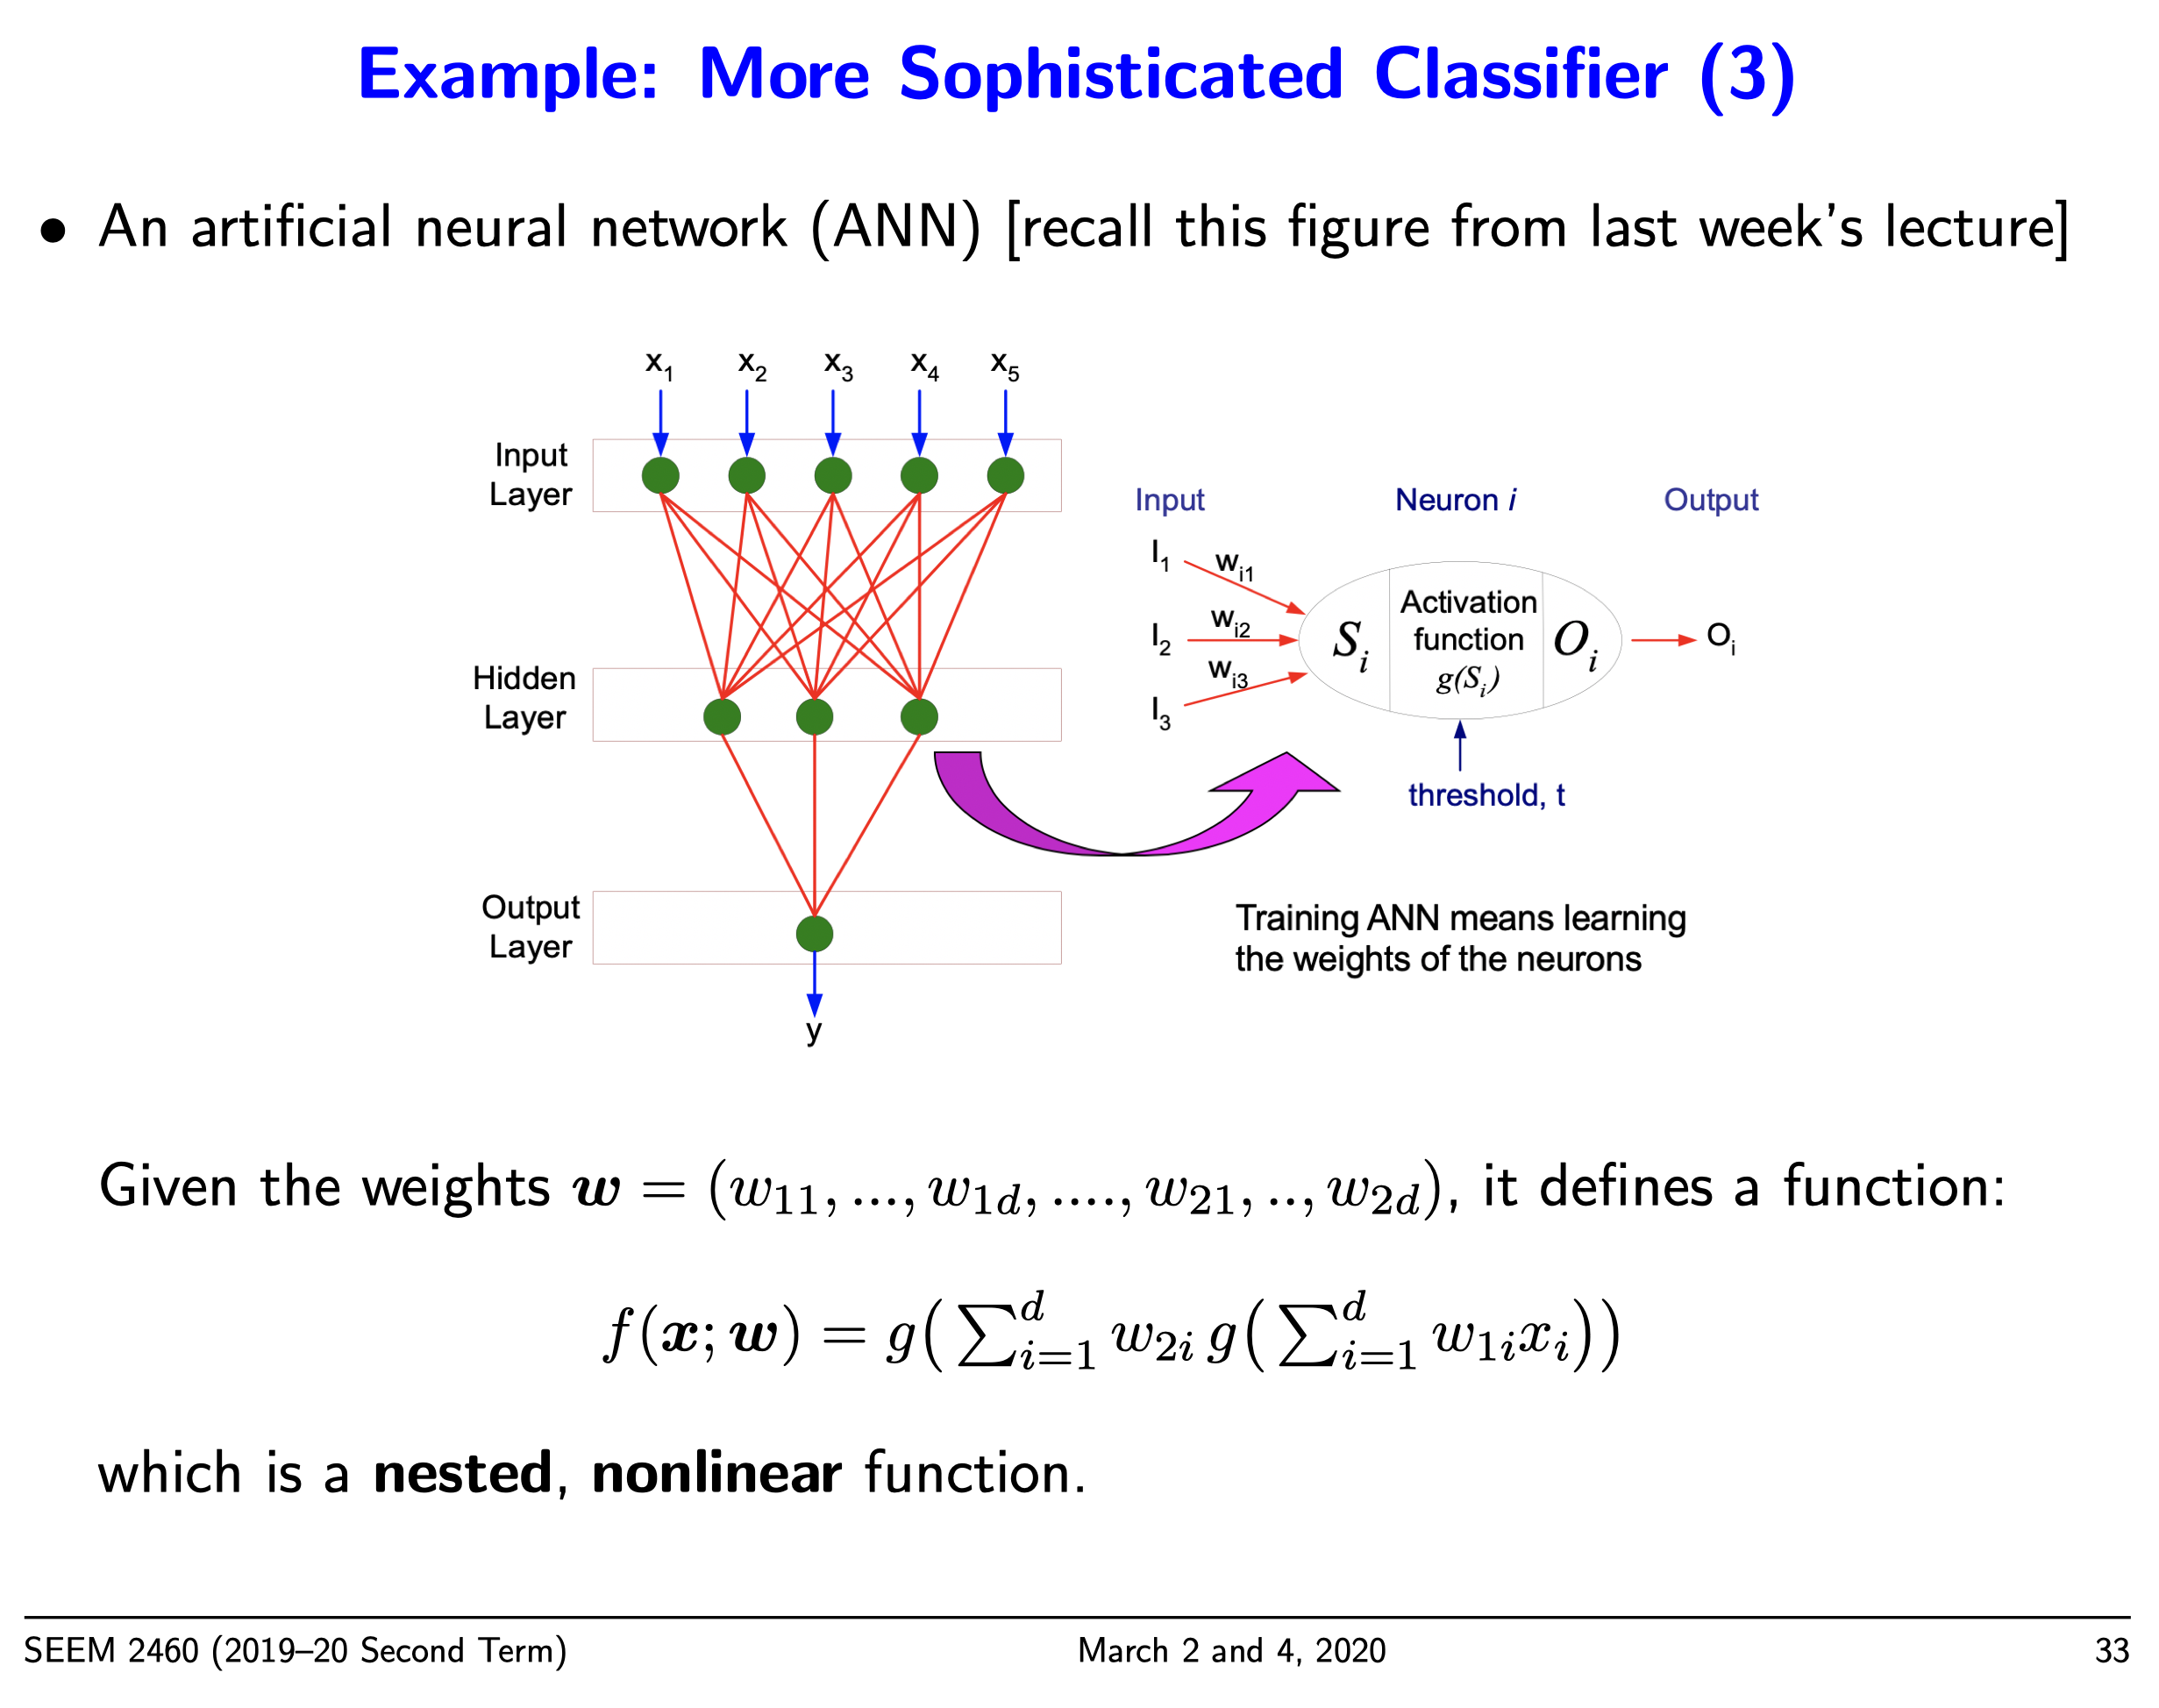

### 1. Task Description:
- Use a multi-class ANN to recognize hand-written digits.
- Dataset: We will use the famous MNIST dataset which consists of grayscale images of hand-written digits.

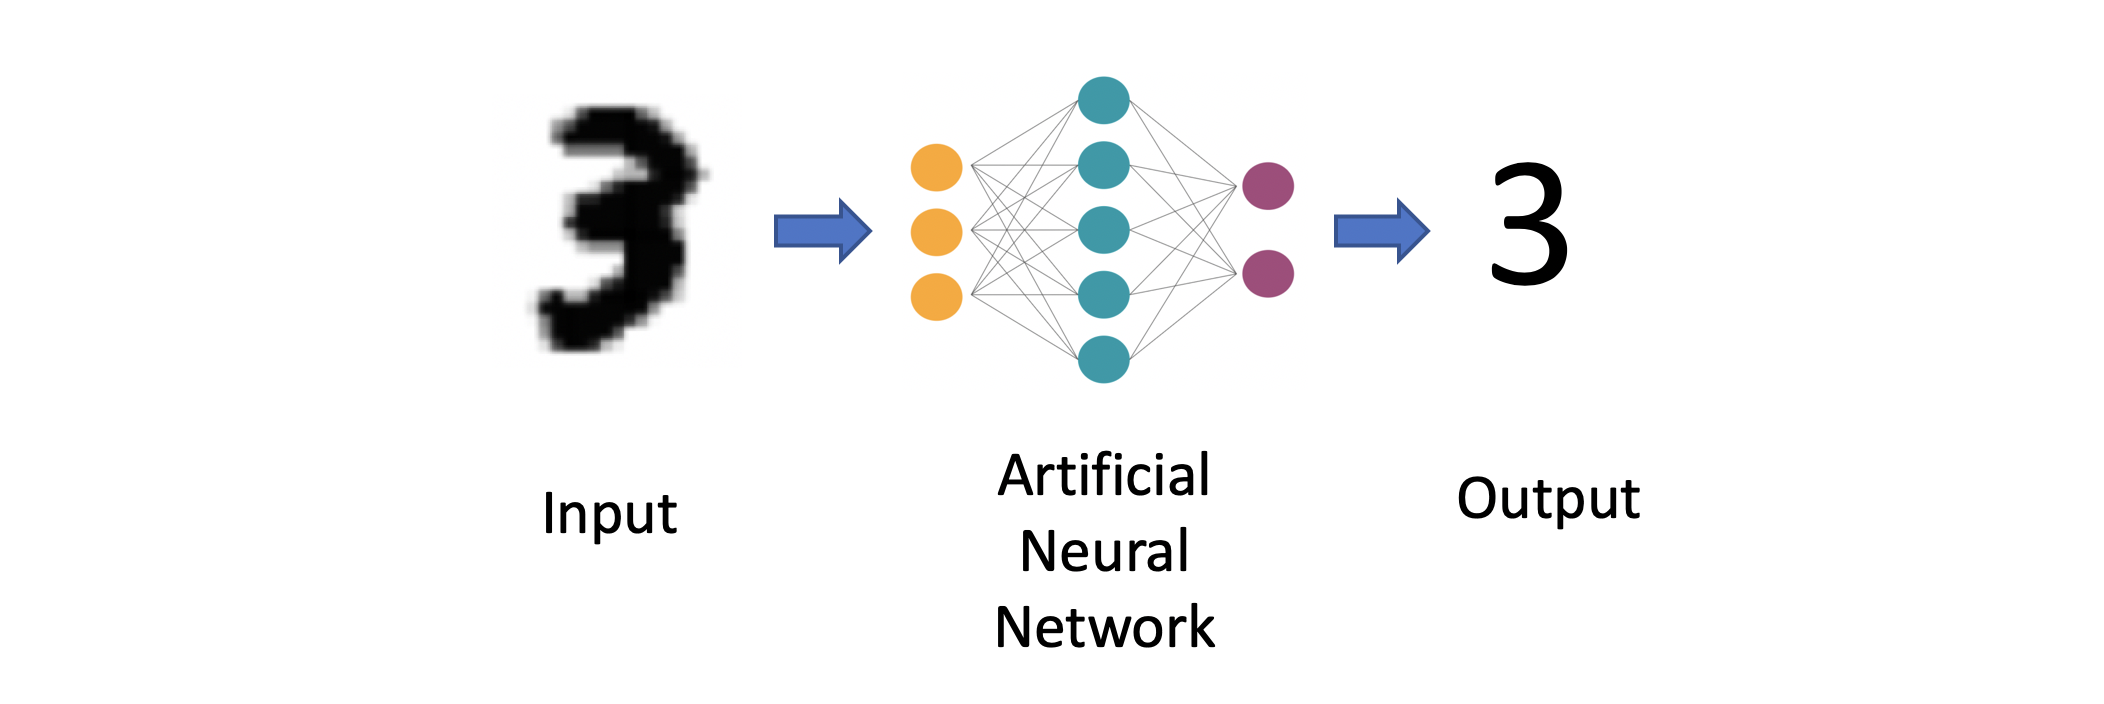

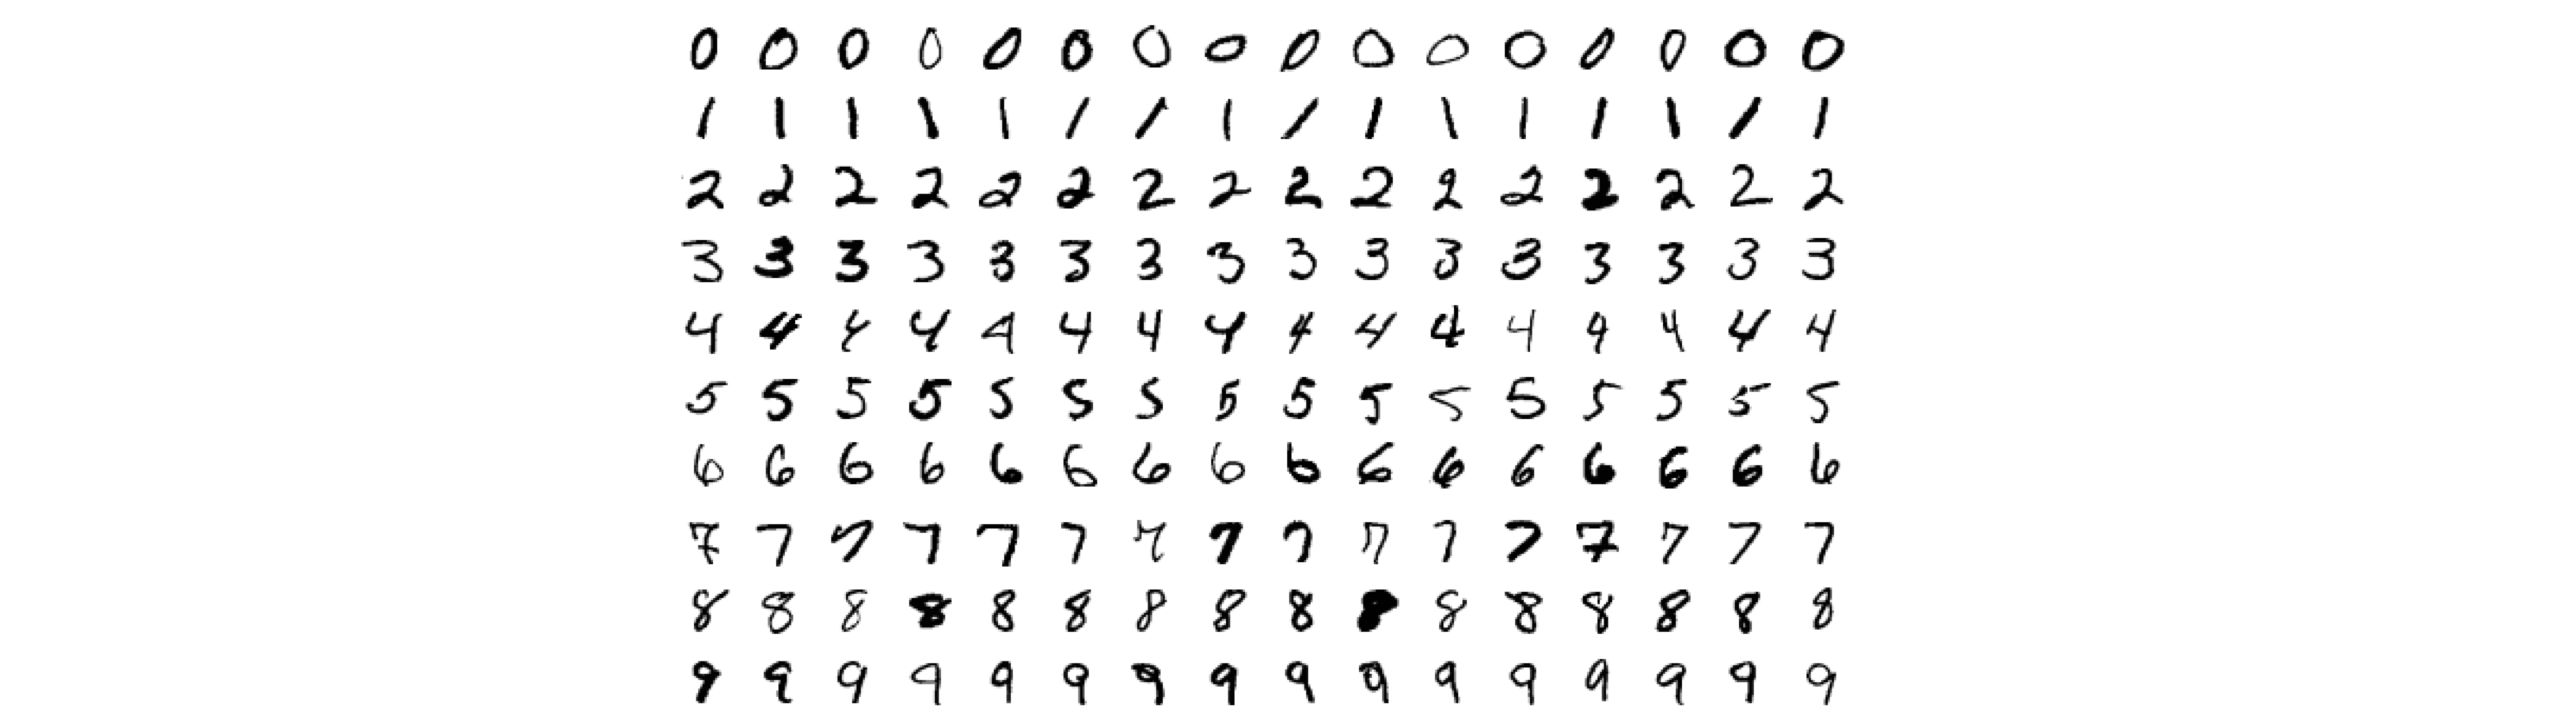

## 2. Import all the necessary libraries

In [0]:
import torch                    # Facebook's PyTorch deep learning toolkit, which is open-source on Github.
import numpy as np              # Numerical Python lib supports scientific numeriacal operations, e.g. Matix operations
import matplotlib.pyplot as plt # We have learn how to use in Tutorial-1

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
from torch.utils import data
from torchvision import transforms
from torchvision.datasets import MNIST  # MNIST dataset

import time
%matplotlib inline

## 3. Download the MNIST Train and Test set & Compute basic data statistics
It is always important to know the shape of the data, as well as the min/max and mean/variance

In [0]:
train = MNIST('./data', train=True, download=True, transform=transforms.ToTensor())
test = MNIST('./data', train=False, download=True, transform=transforms.ToTensor())
train_data = train.data
train_data = train.transform(train_data.numpy())

print('[Training Data]')
print(' - Numpy Shape:', train.data.numpy().shape)
print(' - Tensor Shape:', train.data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

print('\n[Training Labels]')
print(' - Numpy Shape:', train.targets.cpu().numpy().shape)
print(' - Tensor Shape:', train.targets.size())

## 4. Visualize a few training samples
Using the matplotlib.pyplot library, we can visualize our input data.

In [0]:
digit_toshow = 3
selected_idx = train.targets.numpy() == digit_toshow
tensor_toshow = train.data[selected_idx][:10]
grid_img = torchvision.utils.make_grid(tensor_toshow.unsqueeze(1), nrow=5)
plt.figure(figsize=(10,10))
plt.imshow(grid_img.permute(1, 2, 0), cmap='gray')
print(f"Digit {digit_toshow}:")

In [0]:
plt.imshow(np.mean(train.data.numpy(), axis=0), cmap='gray')
print("The mean image of all training samples:")

In [0]:
plt.imshow(np.std(train.data.numpy(), axis=0), cmap='gray')
print("The standard deviation of all training samples:")

## 5. Define our Artificial Neural Network Model 
We define our model using the torch.nn.Module class

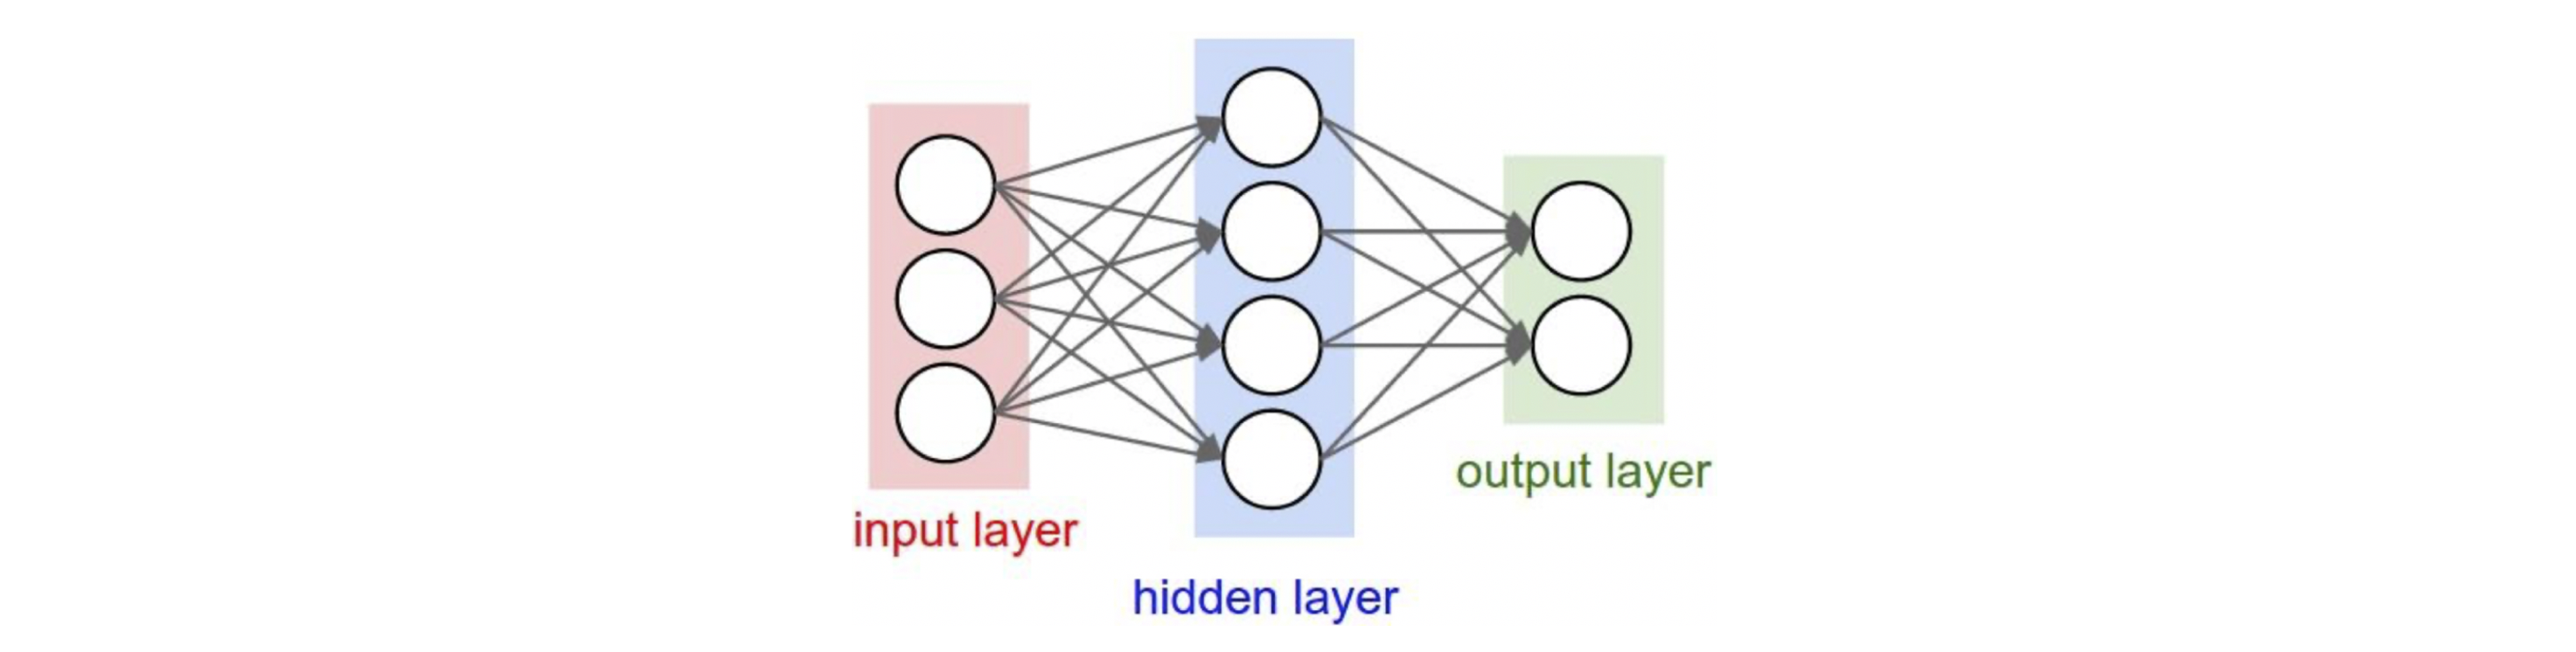

In [0]:
# Define an artificial Neural Network.
class ANNModel(nn.Module):
    def __init__(self, size_list):
        super(ANNModel, self).__init__()
        # 1. Input layer
        self.fc1 = nn.Linear(size_list[0], size_list[1])    # Linear transformation
        self.act1 = nn.ReLU()                               # Activation function

        # 2. Hidden Layer.
        self.fc2 = nn.Linear(size_list[1], size_list[1])
        self.act2 = nn.ReLU()

        # 3. Output Layer.
        self.fc3 = nn.Linear(size_list[1], size_list[2])
        
    def forward(self, x):
        # x = x.view((-1, 784))
        h = self.act1(self.fc1(x))
        h = self.act2(self.fc2(h))      
        h = self.fc3(h)
        out = F.log_softmax(h, dim=-1)
        return out

## 6. Dataloader
We need a dataloader, which help us feed data into our ANN model during the training process.

In [0]:
class MyDataset(data.Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y

    def __len__(self):
        return len(self.Y)

    def __getitem__(self,index):
        X = self.X[index].float().reshape(-1) #flatten the input
        Y = self.Y[index].long()
        return X,Y

# Training
train_dataset = MyDataset(train.data, train.targets)
train_loader_args = dict(shuffle=True, batch_size=64)
train_loader = data.DataLoader(train_dataset, **train_loader_args)

# Testing
test_dataset = MyDataset(test.data, test.targets)
test_loader_args = dict(shuffle=False, batch_size=1)
test_loader = data.DataLoader(test_dataset, **test_loader_args)

We cannot feed all the 60000 images into our model, because the computer does not have such a big memory. Instead, we feed a batch of images into the model at every step.
 
Using the torch.utils.data DataLoader, we shuffle the data and set the batch size to be 64. This means that every step we give 64 images to the model.

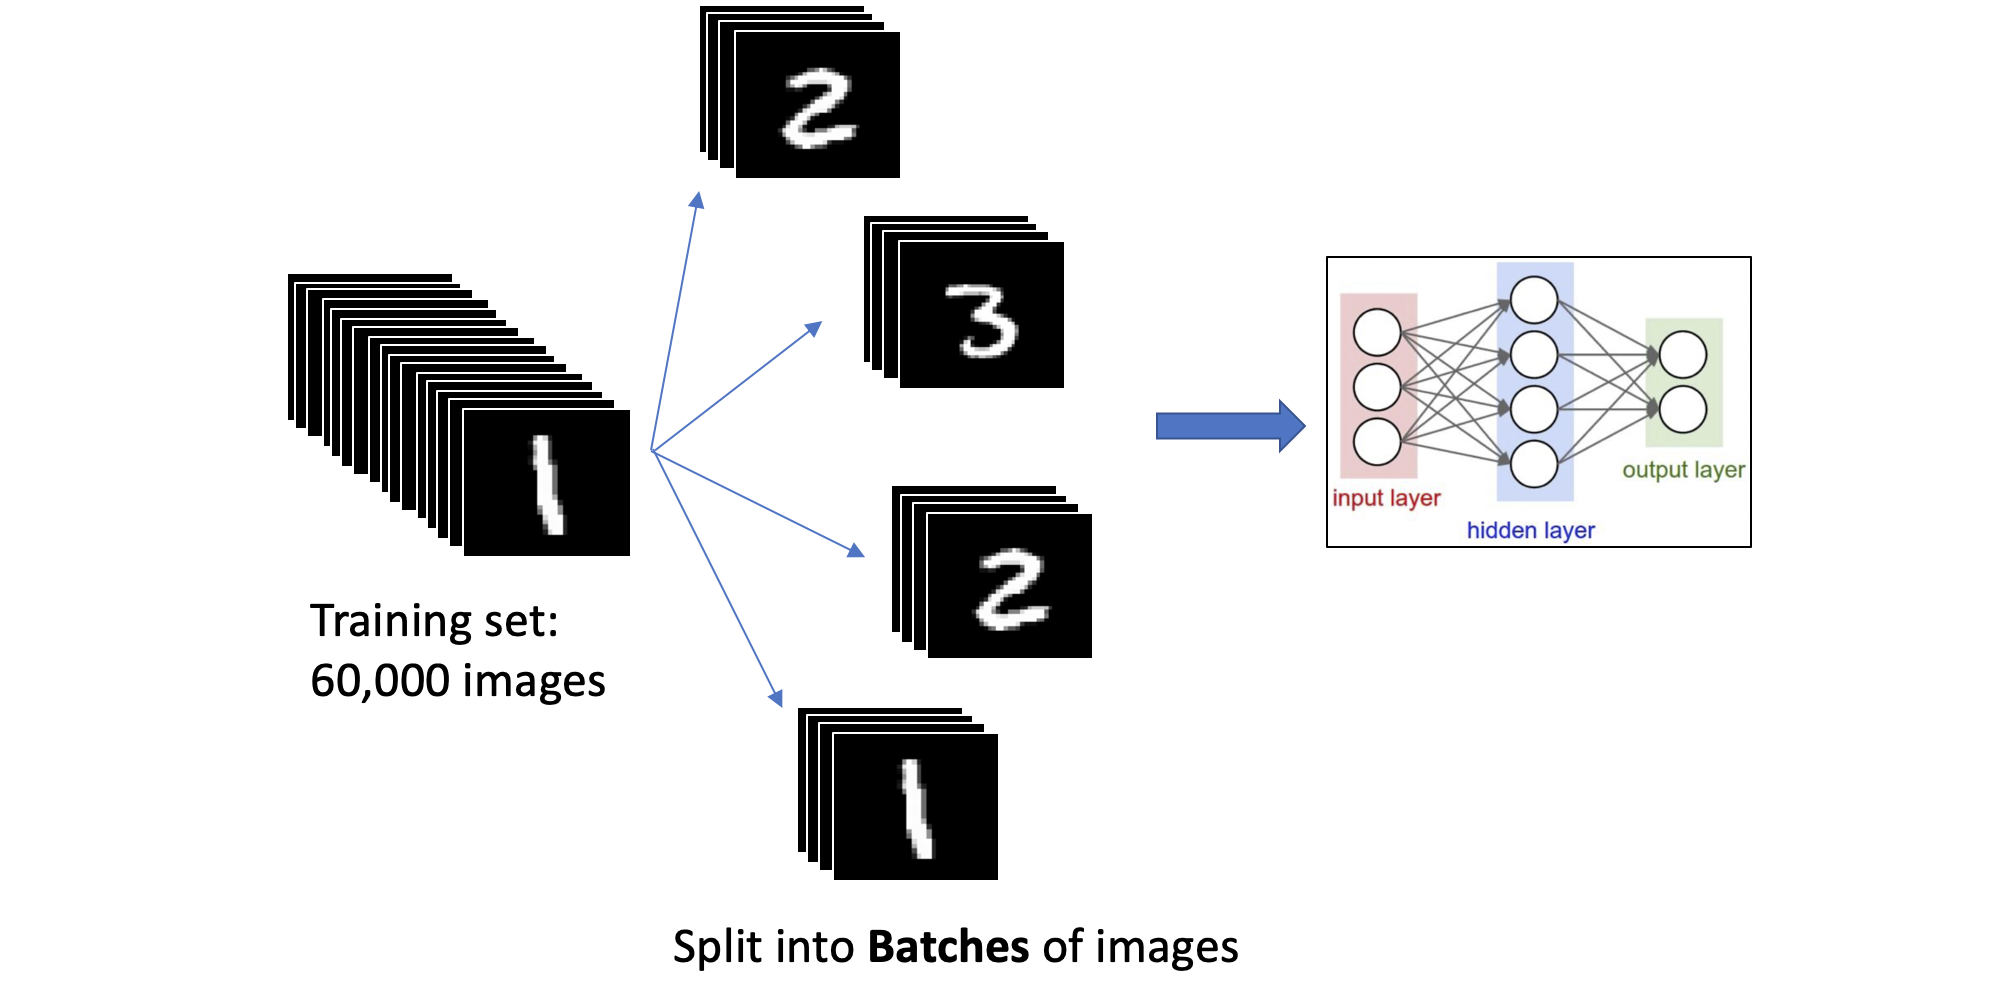

## 7. Create the model and define the Loss and Optimizer


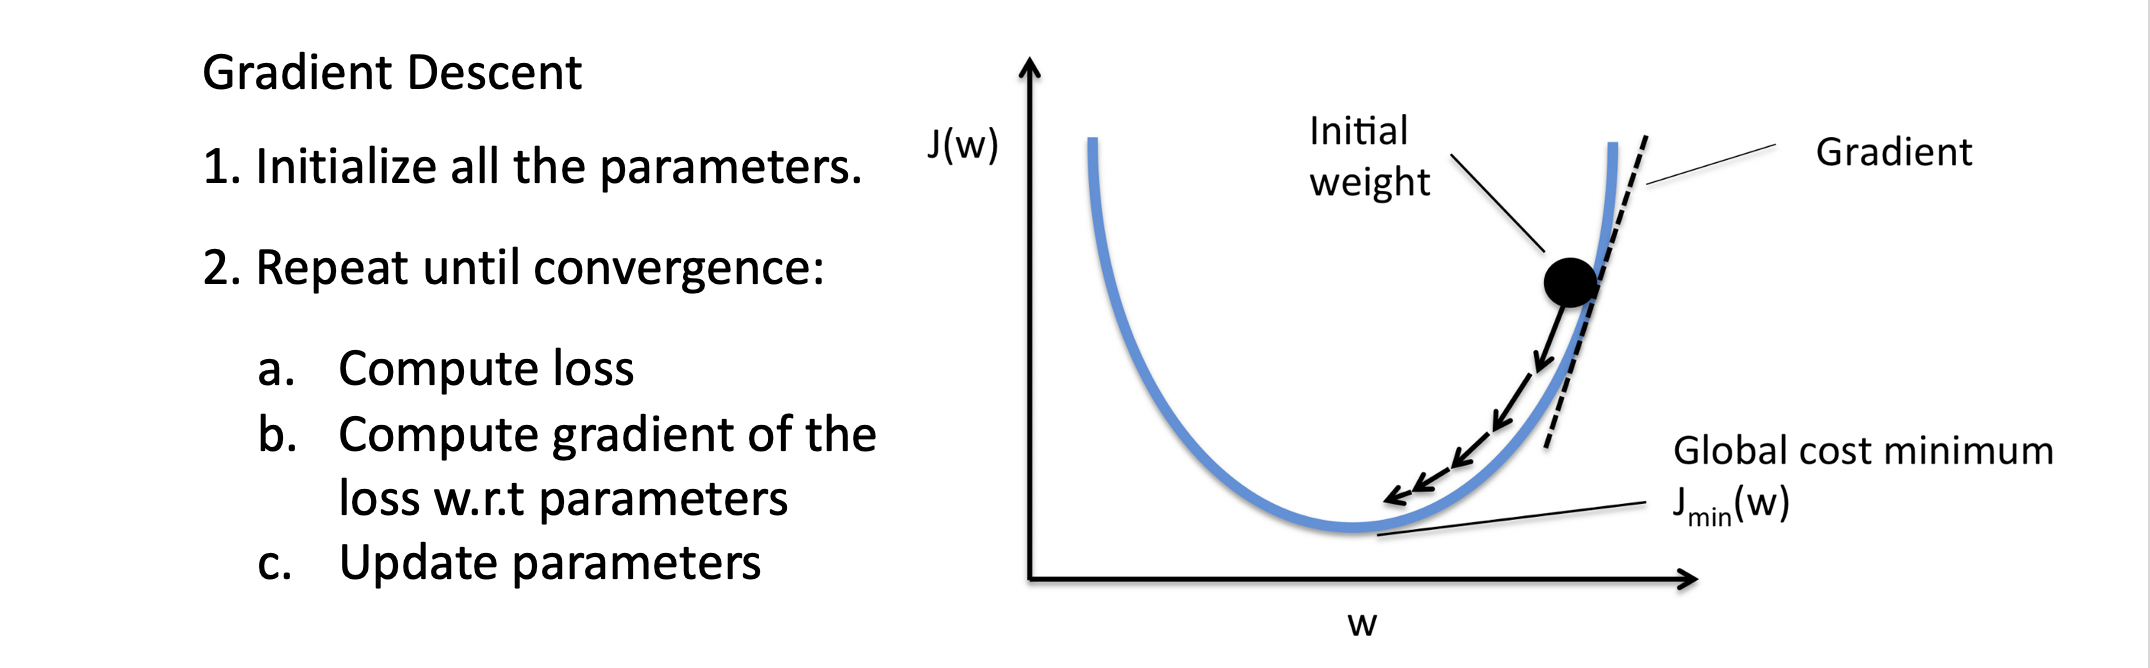

![ChessUrl](https://camo.githubusercontent.com/ffe8ca014b559d500739db0be1624ac4d6034008/68747470733a2f2f707669676965722e6769746875622e696f2f6d656469612f696d672f70617274312f6772616469656e745f64657363656e742e676966 "chess")


In [0]:
model = ANNModel([784, 256, 10])
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)
device = torch.device("cpu")
model.to(device)
print(model)

We create an instance of our ANN model by passing it a list of layer sizes. The input layer contains 28*28 = 784 neurons. We define a single hidden layer of size 256, and our output will be the class probabilities for each of the 10 digits (0-9). 

Since this is a classification task, we will use **Cross Entropy Loss** (a multi-class version of Logistic regression loss). We define our criterion using the torch.nn.CrossEntropyLoss.

In order to train our network, we use the torch.optim.SGD optimizer.

## 8. Create a function that will train the network for one epoch

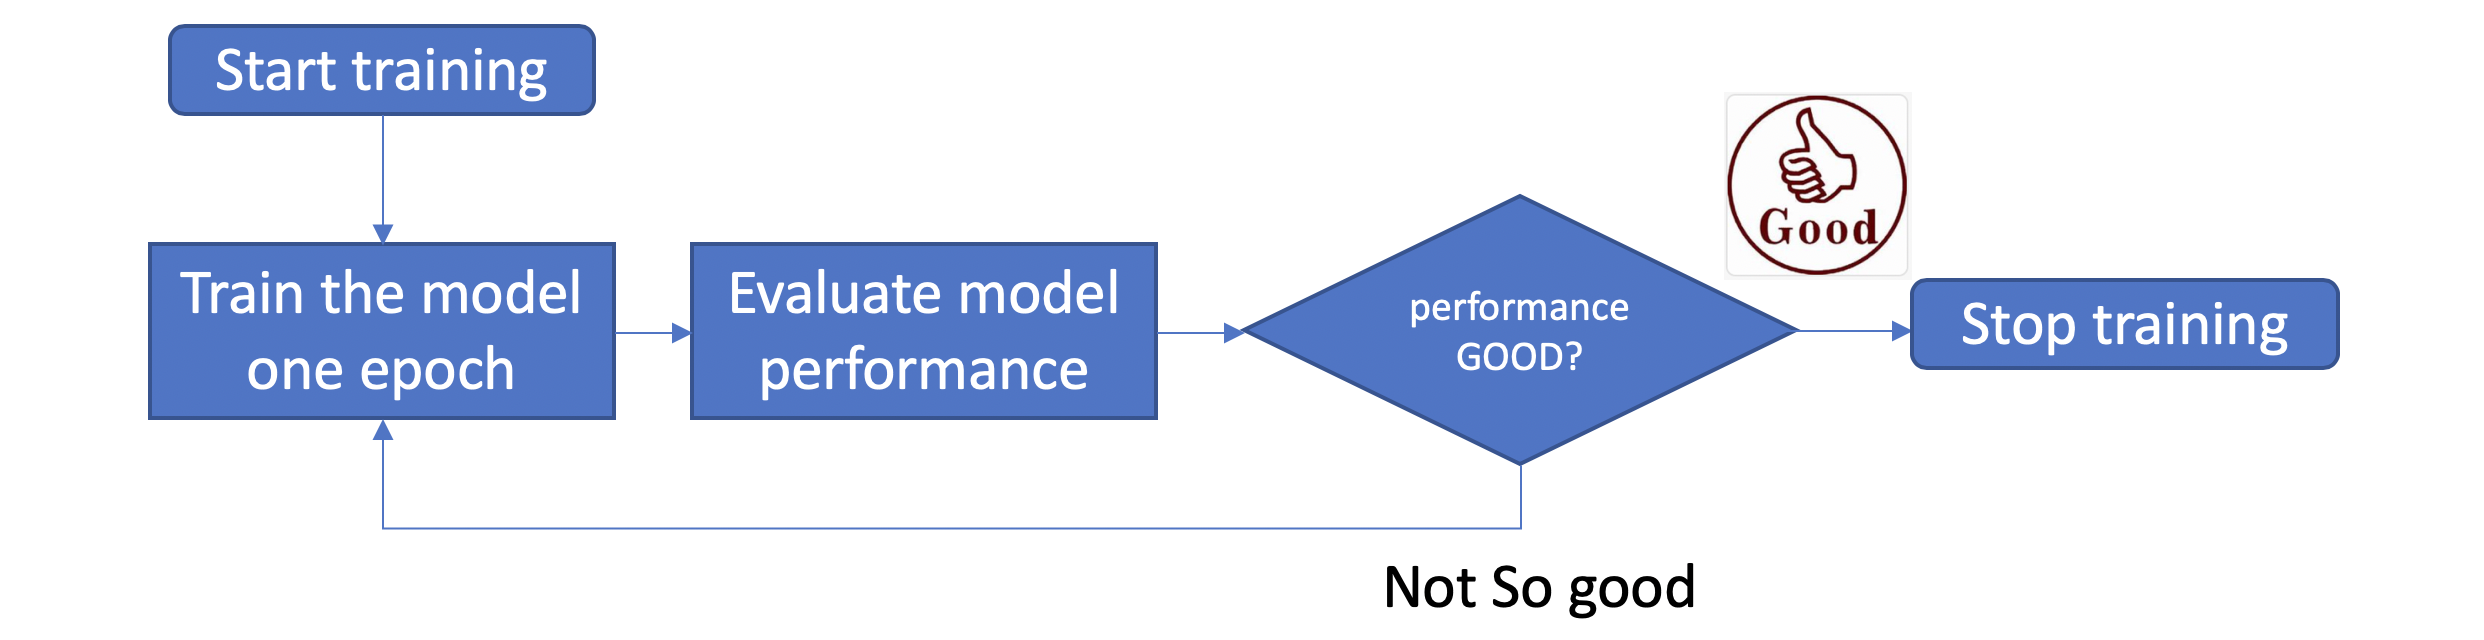

In [0]:
def train_epoch(model, train_loader, criterion, optimizer):
    model.train()

    running_loss = 0.0
    
    start_time = time.time()
    for batch_idx, (data, target) in enumerate(train_loader):   
        optimizer.zero_grad()   # .backward() accumulates gradients
        data = data.to(device)
        target = target.to(device) # all data & model on same device

        outputs = model(data)
        loss = criterion(outputs, target)
        running_loss += loss.item()

        loss.backward()
        optimizer.step()
    
    end_time = time.time()
    
    running_loss /= len(train_loader)
    print('Training Loss: ', running_loss, 'Time: ',end_time - start_time, 's')
    return running_loss

## 9. Create a function that will evaluate our network's performance on the test set

In [0]:
def test_model(model, test_loader, criterion):
    with torch.no_grad():
        model.eval()

        running_loss = 0.0
        total_predictions = 0.0
        correct_predictions = 0.0

        for batch_idx, (data, target) in enumerate(test_loader):   
            data = data.to(device)
            target = target.to(device)

            outputs = model(data)

            _, predicted = torch.max(outputs.data, 1)
            total_predictions += target.size(0)
            correct_predictions += (predicted == target).sum().item()

            loss = criterion(outputs, target).detach()
            running_loss += loss.item()


        running_loss /= len(test_loader)
        acc = (correct_predictions/total_predictions)*100.0
        print('Testing Loss: ', running_loss)
        print('Testing Accuracy: ', acc, '%')
        return running_loss, acc

## 10. Train the model for N epochs
We call our training and testing functions in a loop, while keeping track of the losses and accuracy. 

In [0]:
n_epochs = 10
Train_loss = []
Test_loss = []
Test_acc = []

for i in range(n_epochs):
    print('='*20 + f" Epoch {i+1}" + '='*20)
    train_loss = train_epoch(model, train_loader, criterion, optimizer)
    test_loss, test_acc = test_model(model, test_loader, criterion)
    Train_loss.append(train_loss)
    Test_loss.append(test_loss)
    Test_acc.append(test_acc)
    print('='*20)

## 11. Visualize Training Data

In [0]:
plt.title('Training Loss')
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.plot(Train_loss)

In [0]:
plt.title('Test Loss')
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.plot(Test_loss)

In [0]:
plt.title('Test Accuracy')
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy (%)')
plt.plot(Test_acc)

## 12. Visualize an example

In [0]:
# Visualize a testing instance with matplotlib
plt.imshow(test.data.numpy()[0], cmap='gray')
print("The ground-truth label is: ", test.targets.numpy()[0])

In [0]:
one_test_sample = test.data[:1].float().reshape(1, -1)
with torch.no_grad():
    model.eval()
    recognition_result = torch.argmax(model(one_test_sample).squeeze(0))
print("The recognition result is: ", recognition_result.item())

### Appendix. TensorFlow at a glance. 

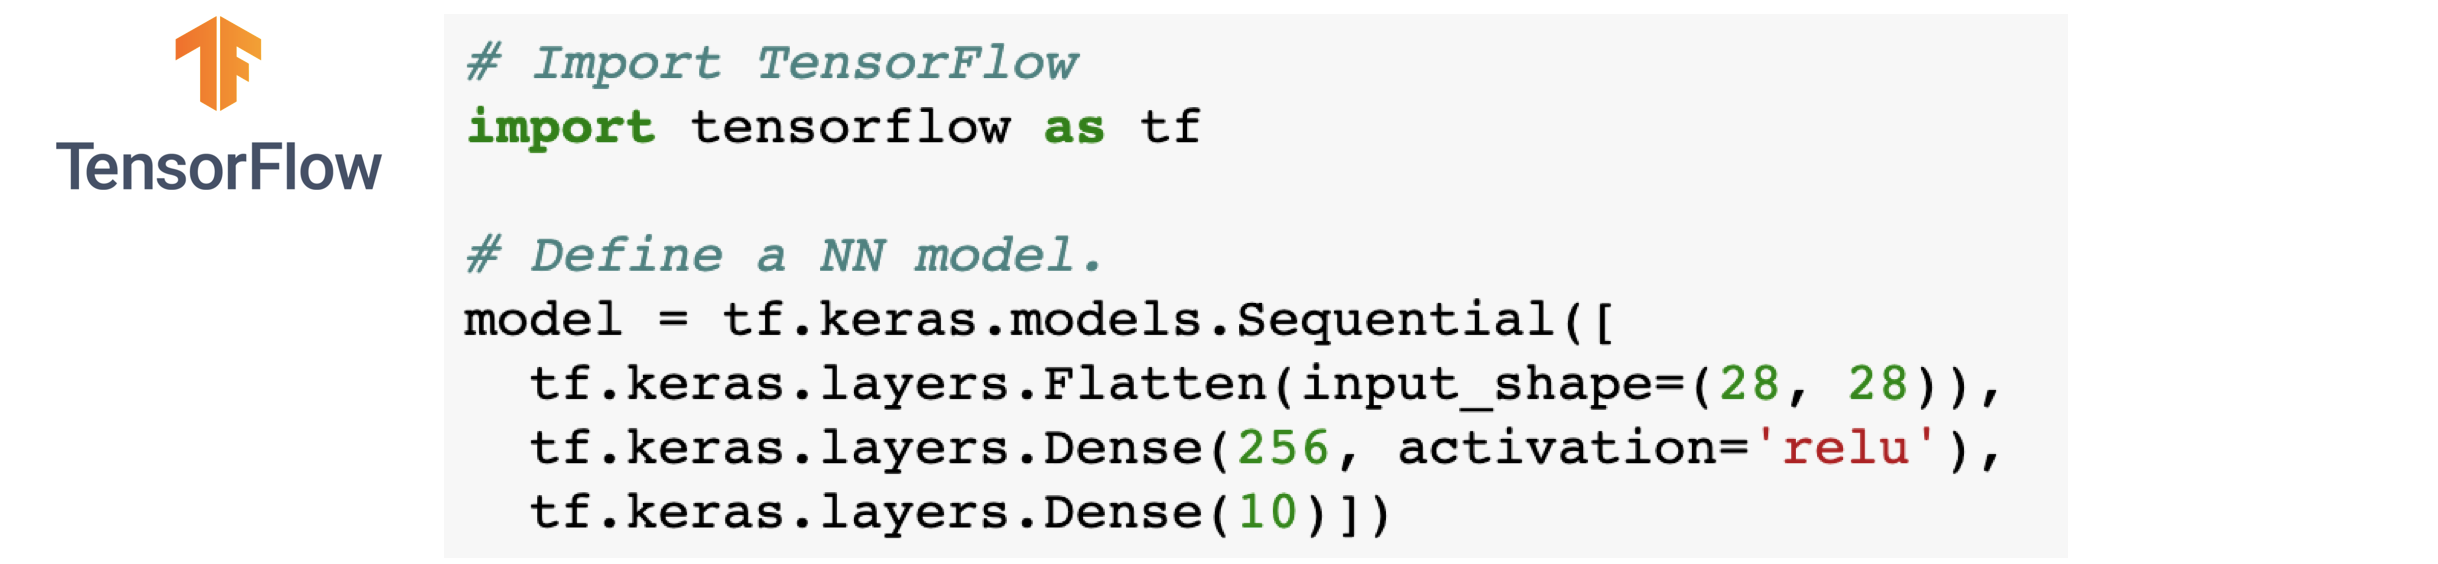